<a href="https://colab.research.google.com/github/krisadas/finrl-multiple/blob/main/FinRLManystock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
# Install the unstable development version in Jupyter notebook:
!pip install git+https://github.com/AI4Finance-LLC/FinRL-Library.git

  Cloning https://github.com/AI4Finance-LLC/FinRL-Library.git to /tmp/pip-req-build-9poijucl
  Running command git clone -q https://github.com/AI4Finance-LLC/FinRL-Library.git /tmp/pip-req-build-9poijucl
     |████████████████████████████████| 6.0MB 8.3MB/s 
     |████████████████████████████████| 3.9MB 51.0MB/s 
  Created wheel for finrl: filename=finrl-0.3.0-cp37-none-any.whl size=38749 sha256=02a8b2fe4bd66f5497de3d6f8ce61c6548bcad53351186b16455264332a398a8
  Stored in directory: /tmp/pip-ephem-wheel-cache-5n4qq62n/wheels/9c/19/bf/c644def96612df1ad42c94d5304966797eaa3221dffc5efe0b
Successfully built finrl
ERROR: tensorflow 1.15.4 has requirement tensorboard<1.16.0,>=1.15.0, but you'll have tensorboard 2.5.0 which is incompatible.
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0


In [ ]:
import os
import pathlib
import pkg_resources
import pip
installedPackages = {pkg.key for pkg in pkg_resources.working_set}
required = {'yfinance', 'pandas', 'matplotlib', 'stockstats','stable-baselines','gym','tensorflow'}
missing = required - installedPackages
if missing:
    !pip install yfinance
    !pip install pandas
    !pip install matplotlib
    !pip install stockstats
    !pip install gym
    !pip install stable-baselines[mpi]
    !pip install tensorflow==1.15.4

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
matplotlib.use('Agg')
import datetime
import os
from finrl.config import config
from finrl.marketdata.yahoodownloader import YahooDownloader
from finrl.preprocessing.preprocessors import FeatureEngineer
from finrl.preprocessing.data import data_split
from finrl.env.env_stocktrading import StockTradingEnv
from finrl.model.models import DRLAgent
from finrl.trade.backtest import backtest_stats, backtest_plot
import sys
sys.path.append("../FinRL-Library")

/usr/local/lib/python3.7/dist-packages/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; multipliers will not be applied'


In [ ]:
!pip install pyfolio

In [7]:
PATH_TO_MODEL_DIR = 'drive/MyDrive/Colab Notebooks/FinRLManystock/'
print(PATH_TO_MODEL_DIR)

import os
if not os.path.exists(PATH_TO_MODEL_DIR + config.DATA_SAVE_DIR):
    os.makedirs(PATH_TO_MODEL_DIR + config.DATA_SAVE_DIR)
if not os.path.exists(PATH_TO_MODEL_DIR + config.TRAINED_MODEL_DIR):
    os.makedirs(PATH_TO_MODEL_DIR + config.TRAINED_MODEL_DIR)
if not os.path.exists(PATH_TO_MODEL_DIR + config.TENSORBOARD_LOG_DIR):
    os.makedirs(PATH_TO_MODEL_DIR + config.TENSORBOARD_LOG_DIR)
if not os.path.exists(PATH_TO_MODEL_DIR + config.RESULTS_DIR):
    os.makedirs(PATH_TO_MODEL_DIR + config.RESULTS_DIR)

drive/MyDrive/Colab Notebooks/FinRLManystock/


In [9]:
dow_30_ticker = ['AAPL','MSFT','JPM','V','RTX','PG','GS','NKE','DIS','AXP',
                 'HD','INTC','WMT','IBM','MRK','UNH','KO','CAT','TRV','JNJ', 
                  'CVX','MCD','VZ','CSCO','XOM','BA','MMM','PFE','WBA','DD']
data_df = YahooDownloader(start_date = '2015-01-01',
                          end_date = '2021-01-01',
                          ticker_list = dow_30_ticker).fetch_data()
data_df.head()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

,date,open,high,low,close,volume,tic,day
0,2015-01-02,27.847500,27.860001,26.837500,24.861401,212818400,AAPL,4
1,2015-01-02,93.169998,93.940002,92.139999,83.982346,2437500,AXP,4
2,2015-01-02,131.070007,131.839996,129.089996,113.657227,4294200,BA,4
3,2015-01-02,91.769997,92.370003,90.660004,75.489723,3767900,CAT,4
4,2015-01-02,27.860001,28.120001,27.379999,22.617912,22926500,CSCO,4


In [10]:
tech_indicator_list=config.TECHNICAL_INDICATORS_LIST
## you can add more technical indicators
## visit https://github.com/jealous/stockstats for different names
tech_indicator_list=tech_indicator_list+['kdjk','open_2_sma','boll','close_10.0_le_5_c','wr_10','dma','trix']
print(tech_indicator_list)

fe = FeatureEngineer(
                    use_technical_indicator=True,
                    tech_indicator_list = tech_indicator_list,
                    use_turbulence=False,
                    user_defined_feature = False)

data_df = fe.preprocess_data(data_df)
data_df.head()

['macd', 'boll_ub', 'boll_lb', 'rsi_30', 'cci_30', 'dx_30', 'close_30_sma', 'close_60_sma', 'kdjk', 'open_2_sma', 'boll', 'close_10.0_le_5_c', 'wr_10', 'dma', 'trix']
Successfully added technical indicators


,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,kdjk,open_2_sma,boll,close_10.0_le_5_c,wr_10,dma,trix
0,2015-01-02,27.847500,27.860001,26.837500,24.861401,212818400,AAPL,4,0.0,25.501705,23.520708,0.0,-66.666667,100.0,24.861401,24.861401,-31.087110,27.847500,24.861401,0.0,293.261330,0.0,-0.447723
1511,2015-01-02,93.169998,93.940002,92.139999,83.982346,2437500,AXP,4,0.0,25.501705,23.520708,0.0,-66.666667,100.0,83.982346,83.982346,-117.734074,93.169998,83.982346,0.0,553.202221,0.0,-0.447723
3022,2015-01-02,131.070007,131.839996,129.089996,113.657227,4294200,BA,4,0.0,25.501705,23.520708,0.0,-66.666667,100.0,113.657227,113.657227,-153.730543,131.070007,113.657227,0.0,661.191628,0.0,-0.447723
4533,2015-01-02,91.769997,92.370003,90.660004,75.489723,3767900,CAT,4,0.0,25.501705,23.520708,0.0,-66.666667,100.0,75.489723,75.489723,-262.383793,91.769997,75.489723,0.0,987.151379,0.0,-0.447723
6044,2015-01-02,27.860001,28.120001,27.379999,22.617912,22926500,CSCO,4,0.0,25.501705,23.520708,0.0,-66.666667,100.0,22.617912,22.617912,-181.174598,27.860001,22.617912,0.0,743.523793,0.0,-0.447723


In [11]:
df = data_df
# add covariance matrix as states
df=df.sort_values(['date','tic'],ignore_index=True)
df.index = df.date.factorize()[0]

cov_list = []
# look back is one year
lookback=252
for i in range(lookback,len(df.index.unique())):
  data_lookback = df.loc[i-lookback:i,:]
  price_lookback=data_lookback.pivot_table(index = 'date',columns = 'tic', values = 'close')
  return_lookback = price_lookback.pct_change().dropna()
  covs = return_lookback.cov().values 
  cov_list.append(covs)
  
df_cov = pd.DataFrame({'date':df.date.unique()[lookback:],'cov_list':cov_list})
df = df.merge(df_cov, on='date')
df = df.sort_values(['date','tic']).reset_index(drop=True)
df.head()        

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,kdjk,open_2_sma,boll,close_10.0_le_5_c,wr_10,dma,trix,cov_list
0,2016-01-04,25.652500,26.342501,25.500000,24.364536,270597600,AAPL,0,-0.611628,27.718532,23.497175,40.591198,-127.963892,46.712236,26.150649,26.433832,-91.558872,26.202500,25.607853,0.0,160.397033,-1.811464,-0.386398,"[[0.0002833225584225907, 8.631800248287042e-05..."
1,2016-01-04,68.089996,68.180000,66.769997,61.870239,9248300,AXP,0,-0.627851,65.472208,62.000238,39.424692,-181.783905,36.141995,64.399716,66.286762,-114.207721,69.049999,63.736223,0.0,223.109378,-2.042933,-0.132045,"[[0.0002833225584225907, 8.631800248287042e-05..."
2,2016-01-04,141.380005,141.699997,139.429993,126.005096,5719500,BA,0,-0.410402,134.397844,125.168183,46.773830,-168.096447,17.581053,130.637846,129.631532,-110.379057,143.670006,129.783014,0.0,241.436905,-2.233667,-0.064523,"[[0.0002833225584225907, 8.631800248287042e-05..."
3,2016-01-04,66.879997,68.080002,65.720001,57.951057,8586900,CAT,0,-0.272237,60.286323,54.655212,46.888988,-46.756230,20.469329,58.519295,59.578289,-98.595014,67.664997,57.470767,0.0,196.227569,-1.624401,-0.103650,"[[0.0002833225584225907, 8.631800248287042e-05..."
4,2016-01-04,26.389999,26.420000,25.879999,22.318188,35827100,CSCO,0,-0.034822,23.398667,21.885882,46.419018,-165.059667,27.857943,22.736948,23.192609,-206.001934,26.884999,22.642274,0.0,283.598478,-0.399256,-0.019393,"[[0.0002833225584225907, 8.631800248287042e-05..."


In [12]:
train = data_split(df, start = '2015-01-01', end = '2019-01-01')
trade = data_split(df, start = '2019-01-01', end = '2021-01-01')
train.to_csv(PATH_TO_MODEL_DIR + config.DATA_SAVE_DIR + '/train_MULTI.csv',index=False)
trade.to_csv(PATH_TO_MODEL_DIR + config.DATA_SAVE_DIR + '/trade_MULTI.csv',index=False)

In [13]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(config.TECHNICAL_INDICATORS_LIST)*stock_dimension
#state_space = 156
print(f"Stock data Dimensions: {stock_dimension}, State Spaces: {state_space}")
env_kwargs = {
    "hmax": 100, 
    "initial_amount": 1000000, 
    #"transaction_cost_pct": 0.001, 
    "buy_cost_pct":0.001,
    "sell_cost_pct":0.001,
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": config.TECHNICAL_INDICATORS_LIST, 
    "action_space": stock_dimension, 
    "reward_scaling": 1e-4}
e_train_gym = StockTradingEnv(df = train, **env_kwargs)
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

Stock data Dimensions: 30, State Spaces: 301
<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


In [14]:
agent = DRLAgent(env = env_train)
A2C_PARAMS = {"n_steps": 5, "ent_coef": 0.005, "learning_rate": 0.0002}
model_a2c = agent.get_model(model_name="a2c",model_kwargs = A2C_PARAMS)
trained_a2c = agent.train_model(model=model_a2c, 
                                tb_log_name='a2c',
                                total_timesteps=100000)

{'n_steps': 5, 'ent_coef': 0.005, 'learning_rate': 0.0002}
Using cuda device
Logging to tensorboard_log/a2c/a2c_1
------------------------------------
| time/                 |          |
|    fps                | 137      |
|    iterations         | 100      |
|    time_elapsed       | 3        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -42.6    |
|    explained_variance | -0.109   |
|    learning_rate      | 0.0002   |
|    n_updates          | 99       |
|    policy_loss        | 12       |
|    std                | 1        |
|    value_loss         | 0.494    |
------------------------------------
------------------------------------
| environment/          |          |
|    portfolio_value    | 1.4e+06  |
|    total_cost         | 1.05e+05 |
|    total_reward       | 3.99e+05 |
|    total_reward_pct   | 39.9     |
|    total_trades       | 20635    |
| time/                 |          |
|    fps                | 163      

In [15]:
trained_a2c.save(PATH_TO_MODEL_DIR + config.TRAINED_MODEL_DIR+'/trained_a2c.model')

In [16]:
trade.head()

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,kdjk,open_2_sma,boll,close_10.0_le_5_c,wr_10,dma,trix,cov_list
0,2019-01-02,38.722500,39.712502,38.557499,38.505024,148158800,AAPL,2,-2.016889,44.505522,35.444587,37.867340,-91.571542,42.250808,41.225720,46.488189,26.255061,39.177500,39.975055,0.0,64.517199,-6.875741,-0.761653,"[[0.000326521211026904, 0.00013581657890599075..."
0,2019-01-02,93.910004,96.269997,93.769997,92.042946,4175400,AXP,2,-3.403805,109.907410,84.174485,41.204998,-97.759092,26.709417,99.719922,100.286694,12.477660,94.520000,97.040948,0.0,77.862844,-8.854515,-0.588183,"[[0.000326521211026904, 0.00013581657890599075..."
0,2019-01-02,316.190002,323.950012,313.709991,314.645142,3292200,BA,2,-5.550592,339.116375,287.252015,47.010000,-21.712382,13.611972,314.427160,331.956148,38.428540,318.345001,313.184195,0.0,45.927493,-20.473652,-0.326732,"[[0.000326521211026904, 0.00013581657890599075..."
0,2019-01-02,124.029999,127.879997,123.000000,118.137177,4783200,CAT,2,-0.680049,125.145761,109.015061,48.229091,-5.147002,0.873482,117.640500,119.834356,5.270111,125.314999,117.080411,0.0,84.081026,-1.440679,-0.134240,"[[0.000326521211026904, 0.00013581657890599075..."
0,2019-01-02,42.279999,43.200001,42.209999,39.772106,23833500,CSCO,2,-0.945558,46.120801,36.852423,44.872560,-87.538213,29.529377,41.863034,42.137596,-13.193947,42.734999,41.486612,0.0,110.233277,-2.565600,-0.392871,"[[0.000326521211026904, 0.00013581657890599075..."


In [17]:
e_trade_gym = StockTradingEnv(df = trade, **env_kwargs)
df_account_value, df_actions = DRLAgent.DRL_prediction(model=trained_a2c, environment = e_trade_gym)

hit end!


In [18]:
print(df_account_value)
df_actions.head()

           date  account_value
0    2019-01-02   1.000000e+06
1    2019-01-03   9.972432e+05
2    2019-01-04   1.001832e+06
3    2019-01-07   1.003586e+06
4    2019-01-08   1.005752e+06
..          ...            ...
500  2020-12-24   1.374198e+06
501  2020-12-28   1.389277e+06
502  2020-12-29   1.382473e+06
503  2020-12-30   1.375944e+06
504  2020-12-31   1.391769e+06

[505 rows x 2 columns]


,AAPL,AXP,BA,CAT,CSCO,CVX,DD,DIS,GS,HD,IBM,INTC,JNJ,JPM,KO,MCD,MMM,MRK,MSFT,NKE,PFE,PG,RTX,TRV,UNH,V,VZ,WBA,WMT,XOM
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-01-02,100,0,0,72,37,0,100,0,0,57,0,43,0,0,100,100,0,0,62,100,0,0,39,100,0,100,100,0,100,0
2019-01-03,100,0,0,-47,-37,39,-100,0,0,0,100,-43,0,0,100,100,0,66,21,100,0,100,100,-58,47,100,-15,0,-98,0
2019-01-04,42,61,0,-25,58,-39,0,100,0,98,100,0,0,0,76,100,44,-66,-37,100,0,100,-100,-42,-47,-56,100,0,100,0
2019-01-07,-57,0,0,56,100,0,0,-100,0,-40,-58,0,13,0,25,100,-44,100,100,100,58,100,-39,0,65,-85,56,0,88,0
2019-01-08,59,-22,80,-56,100,73,0,0,0,100,16,45,2,32,100,100,0,100,-84,-62,-58,99,0,100,-65,100,-13,100,100,0


In [19]:
from finrl.trade.backtest import backtest_stats, backtest_plot
print("==============Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)

==============Results===========
Annual return          0.179347
Cumulative returns     0.391769
Annual volatility      0.236606
Sharpe ratio           0.817426
Calmar ratio           0.620248
Stability              0.555899
Max drawdown          -0.289153
Omega ratio            1.202591
Sortino ratio          1.159322
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.001289
Daily value at risk   -0.029042
dtype: float64


[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (505, 8)


Start date,2019-01-02
End date,2020-12-31
Total months,24
,Backtest
Annual return,17.935%
Cumulative returns,39.177%
Annual volatility,23.661%
Sharpe ratio,0.82
Calmar ratio,0.62
Stability,0.56
Max drawdown,-28.915%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,28.92,2020-02-14,2020-03-23,2020-08-07,126
1,9.00,2019-09-06,2019-11-04,2020-01-29,104
2,6.71,2020-10-16,2020-12-10,NaT,NaN
3,3.50,2019-07-18,2019-08-05,2019-08-08,16
4,3.06,2020-09-16,2020-09-23,2020-10-05,14


/usr/local/lib/python3.7/dist-packages/pyfolio/tears.py:907: UserWarning: Passed returns do not overlap with anyinteresting times.
  'interesting times.', UserWarning)


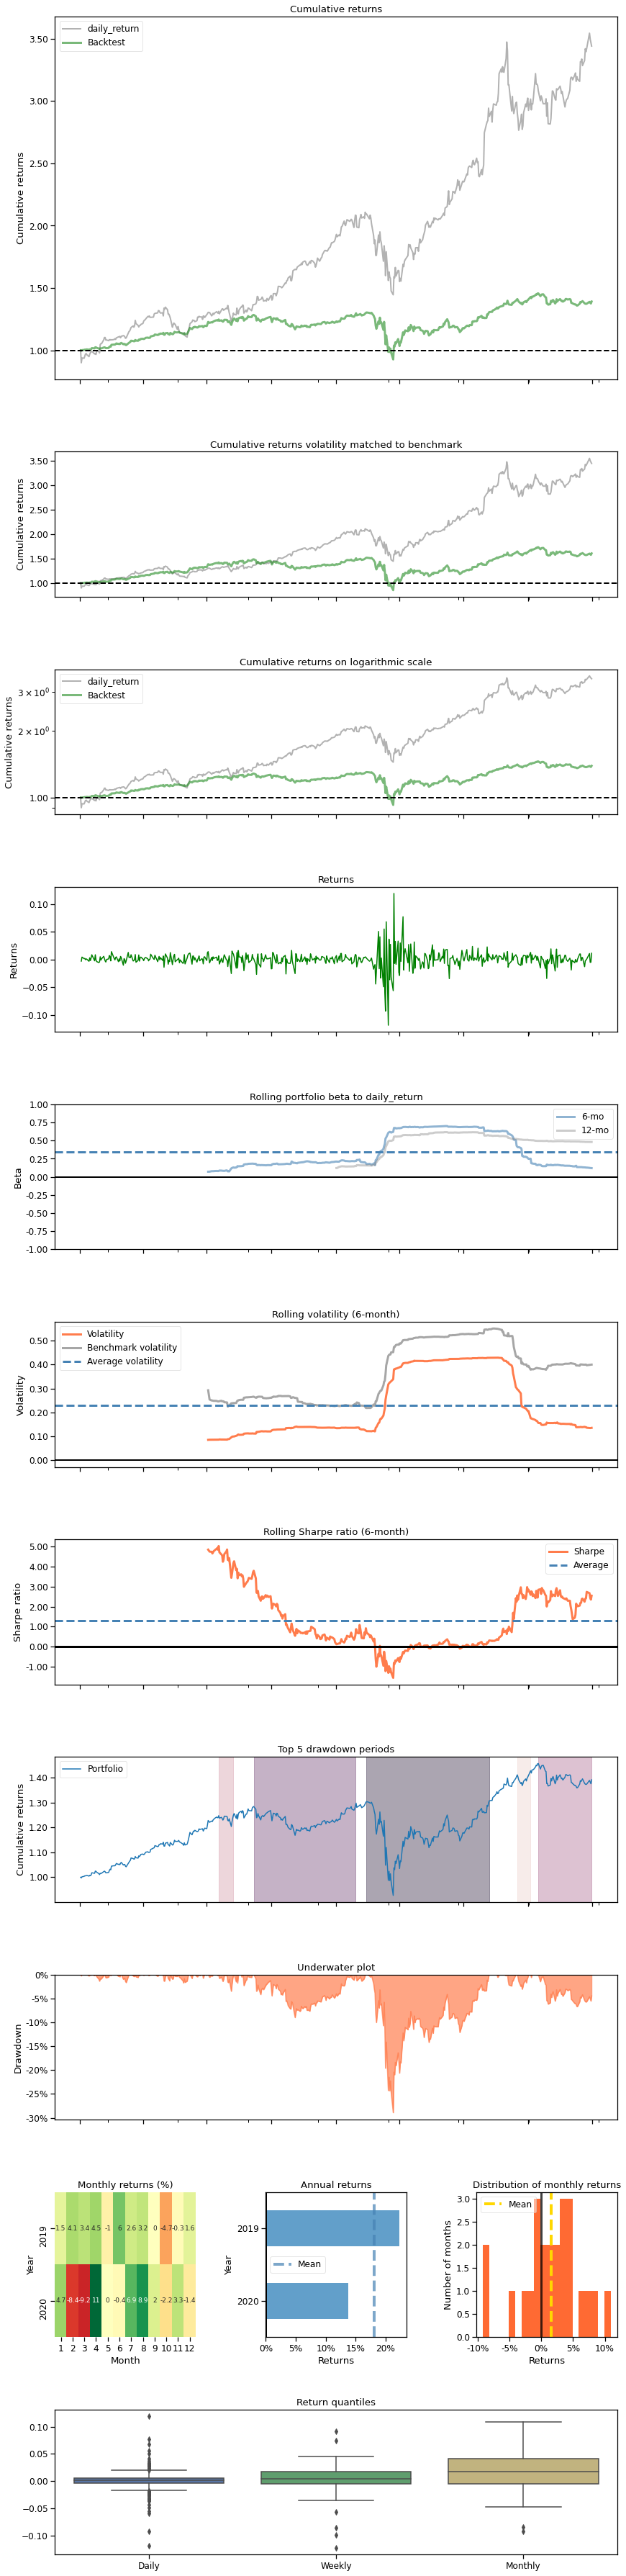

In [22]:
%matplotlib inline
backtest_plot(account_value=df_account_value, baseline_ticker = 'AAPL',
             baseline_start = '2019-01-01', baseline_end = '2021-01-01')